following https://scanpy.readthedocs.io/en/stable/tutorials/basics/index.html

samples were collected from bone marrow mononuclear cells (BMMCs) of healthy human donors
samples were measured using 10x multiome gene expression and chromatin accessability kit

In [2]:
# core scverse libraries
import scanpy as sc
import anndata as ad

# data retrieval
import pooch

In [3]:
sc.settings.set_figure_params(dpi=50, facecolor='white')

read count matrix into an AnnData object (has slots for annotations and different representations of the data)

In [4]:
# establish data retrieval
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
) 
EXAMPLE_DATA.load_registry_from_doi()

In [7]:
# define specific samples to retrieve
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5", # sample : filename
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {} # dictionary to hold the 2 samples

for sample_id, filename in samples.items(): # for each sample
    path = EXAMPLE_DATA.fetch(filename) # retrieve file from example_data
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata # store sample_adata into adatas dictionary

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/opt/anaconda3/envs/bio/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/bio/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/opt/anaconda3/envs/bio/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/bio/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/bio/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

8000+ cells per sample
36601 measured genes

Quality Control
calculate proportion of counts of a specific gene type in a gene population

In [ ]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL")) # or
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]") # regular expression

In [10]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

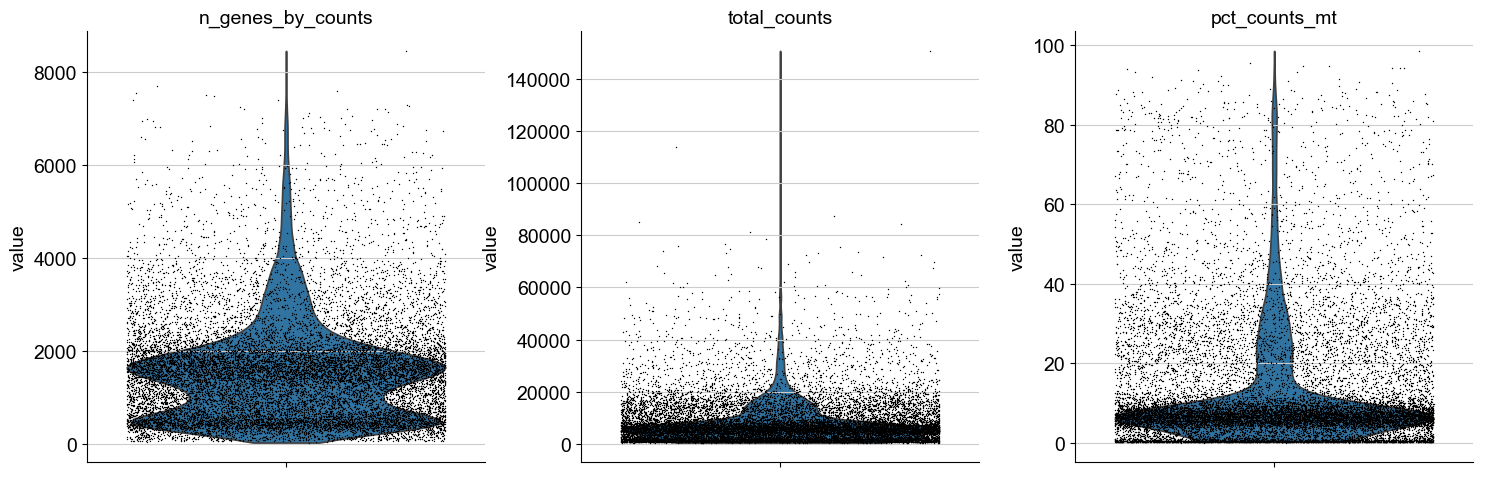

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

each point is a cell
first graph is number of genes for a given cell
most cells had similar counts and pct counts of mt

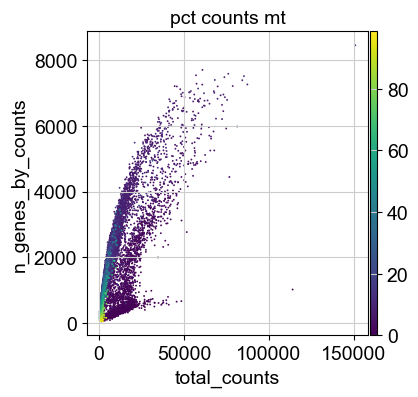

In [12]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

start with permissive filtering strategy. revisit later. 

what appears to be poor QC metrics may be driven by real biology

multiple batches: perform QC for each sample individually (thresholds may vary between batches)

In [13]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
# doublet detection
sc.pp.scrublet(adata, batch_key="sample") 
# adds doublet_score and predicted_doublet to .obs attribute of adata
# doublet_score is a number between 0 and 1, higher score means more likely to be a doublet
# predicted_doublet is a boolean, True means likely to be a doublet

In [ ]:
# Saving count data
adata.layers["counts"] = adata.X.copy() # make a copy and save it in the .layers attribute

In [19]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

Feature selection
include only the most informative genes in the dimensionality reduction of the dataset

In [21]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

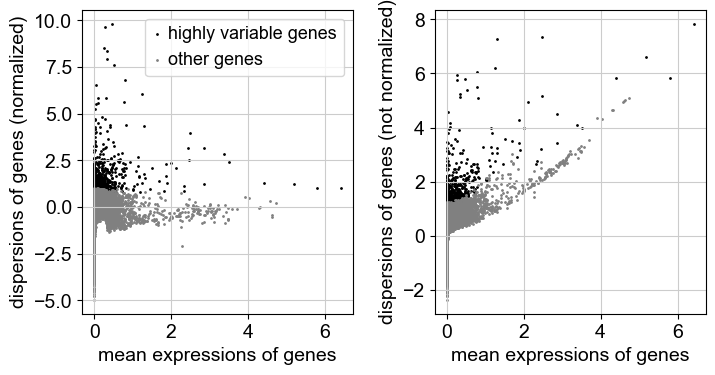

In [22]:
sc.pl.highly_variable_genes(adata)

In [23]:
sc.tl.pca(adata)

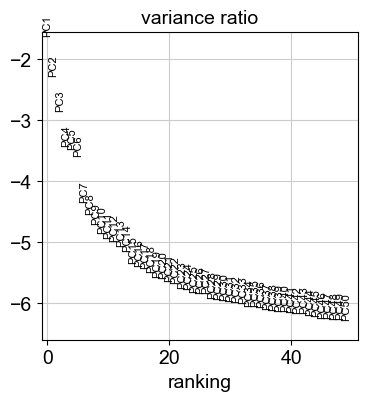

In [26]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
# generally no significant downside to overestimating the number of PCs

# can be used to see if there are any undesired features (batch, QC) driving significant variation 
# in the dataset. so maybe check what the first few PCs are capturing

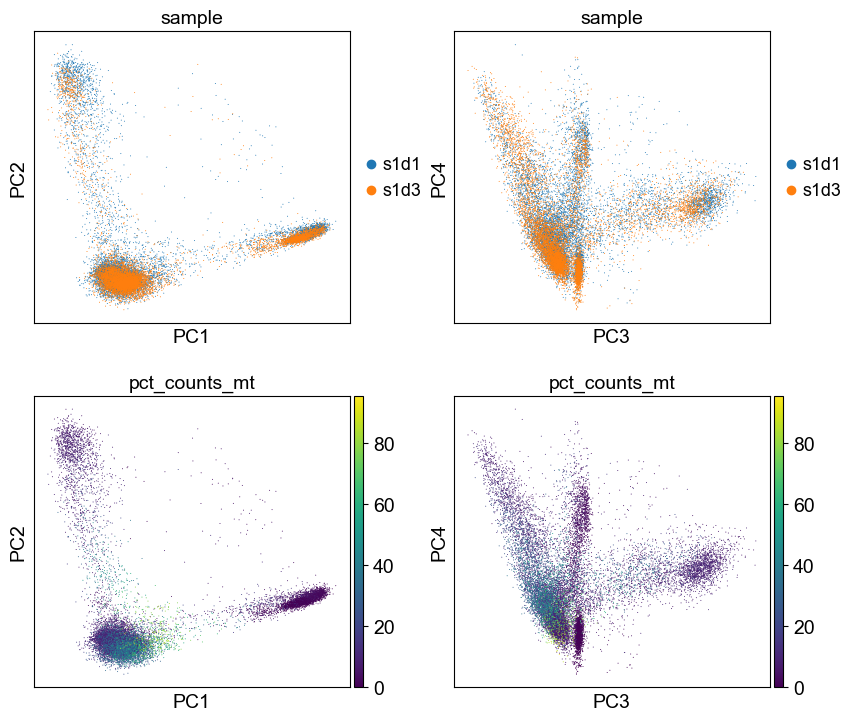

In [ ]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"], # what to color by
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)], # PCs plotted, corresponds to color list
    ncols=2,
    size=2,
)

In [ ]:
sc.pp.neighbors(adata) # compute a neighborhood graph using the PCA representation of the data
# pp = preprocessing

/opt/anaconda3/envs/bio/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
sc.tl.umap(adata)

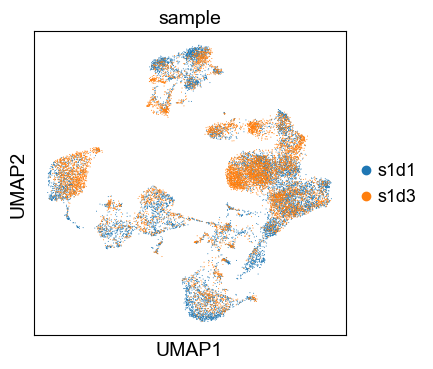

In [30]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

minor batch effect
clustering + data annotation

In [ ]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, 
# especially for larger datasets
# Leiden graph-clustering method (community detection based on optimizing modularity)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

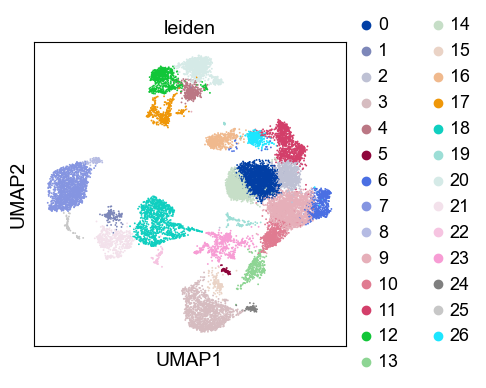

In [33]:
sc.pl.umap(adata, color=["leiden"])

reassess QC and cell filtering

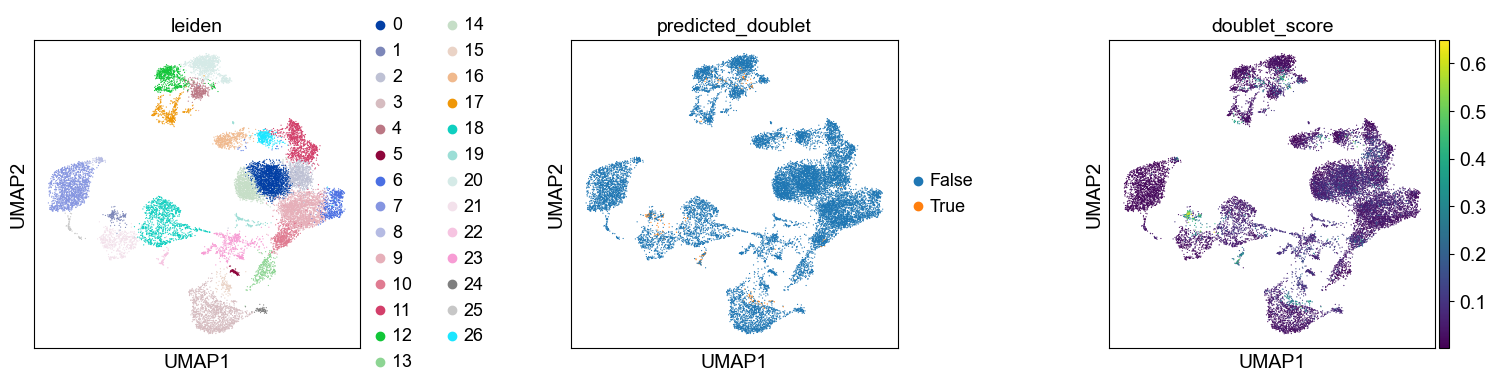

In [34]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

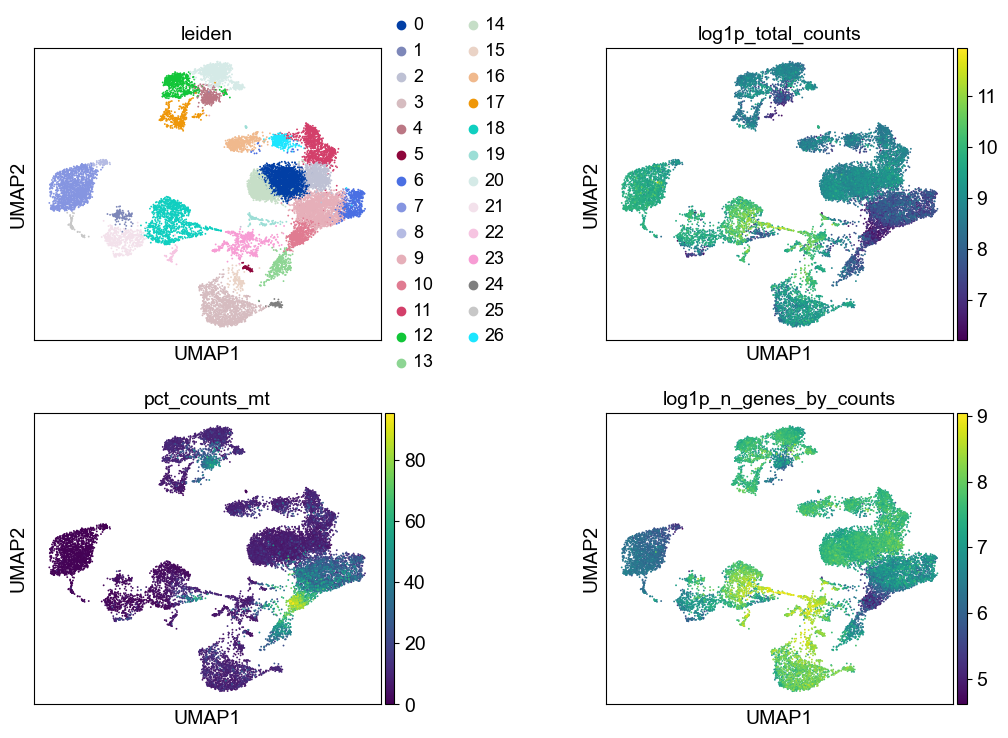

In [35]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

Manual cell-type annotation
use genes exclusively expressed by a given cell type (marker genes of cell types)
can distinguish the heterogenous groups of cells in our data

In [ ]:
for res in [0.02, 0.5, 2.0]: # three different resolutions
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )
# use leiden clustering algorithm to extract cell communities from the NN graph

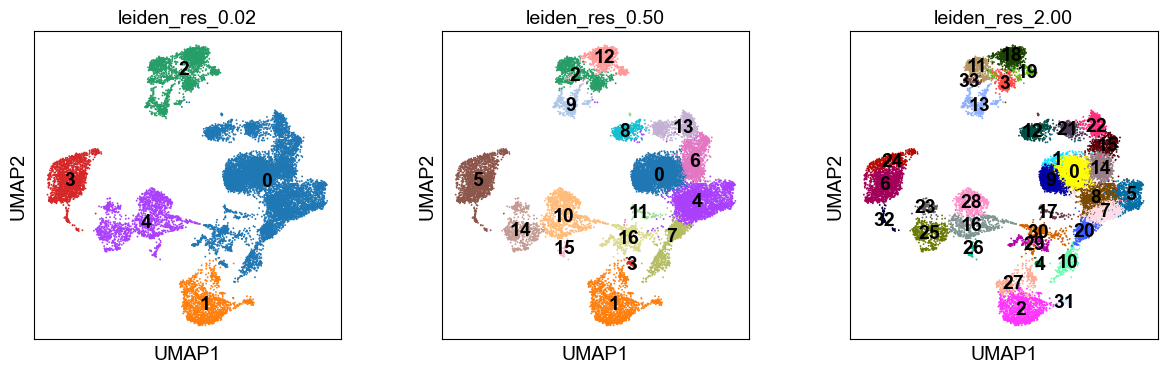

In [ ]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)
# num of clusters based on the num of stable and biologically-meaningful groups we can distinguish
# done by experts in the field / expert-curated prior knowledge with cell types

# res of 2 is likely over-clustered
# res of 0.02 is likely grouping cells that belong to distinct cell identities

In [ ]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],

    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],

    # Note IGHD and IGHM are negative markers
    "B cells": ["MS4A1", "ITGB1", "COL4A4", "PRDM1", "IRF4", "PAX5", "BCL11A", "BLK", "IGHD", "IGHM"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],

    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

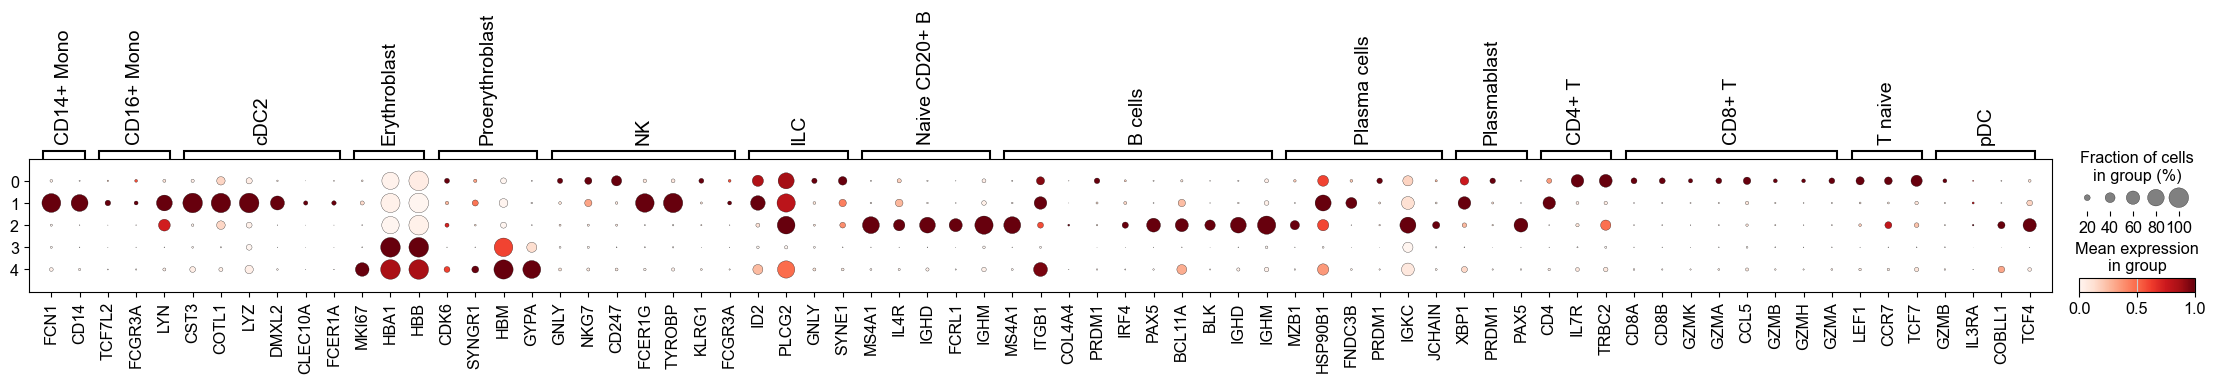

In [40]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

In [41]:
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

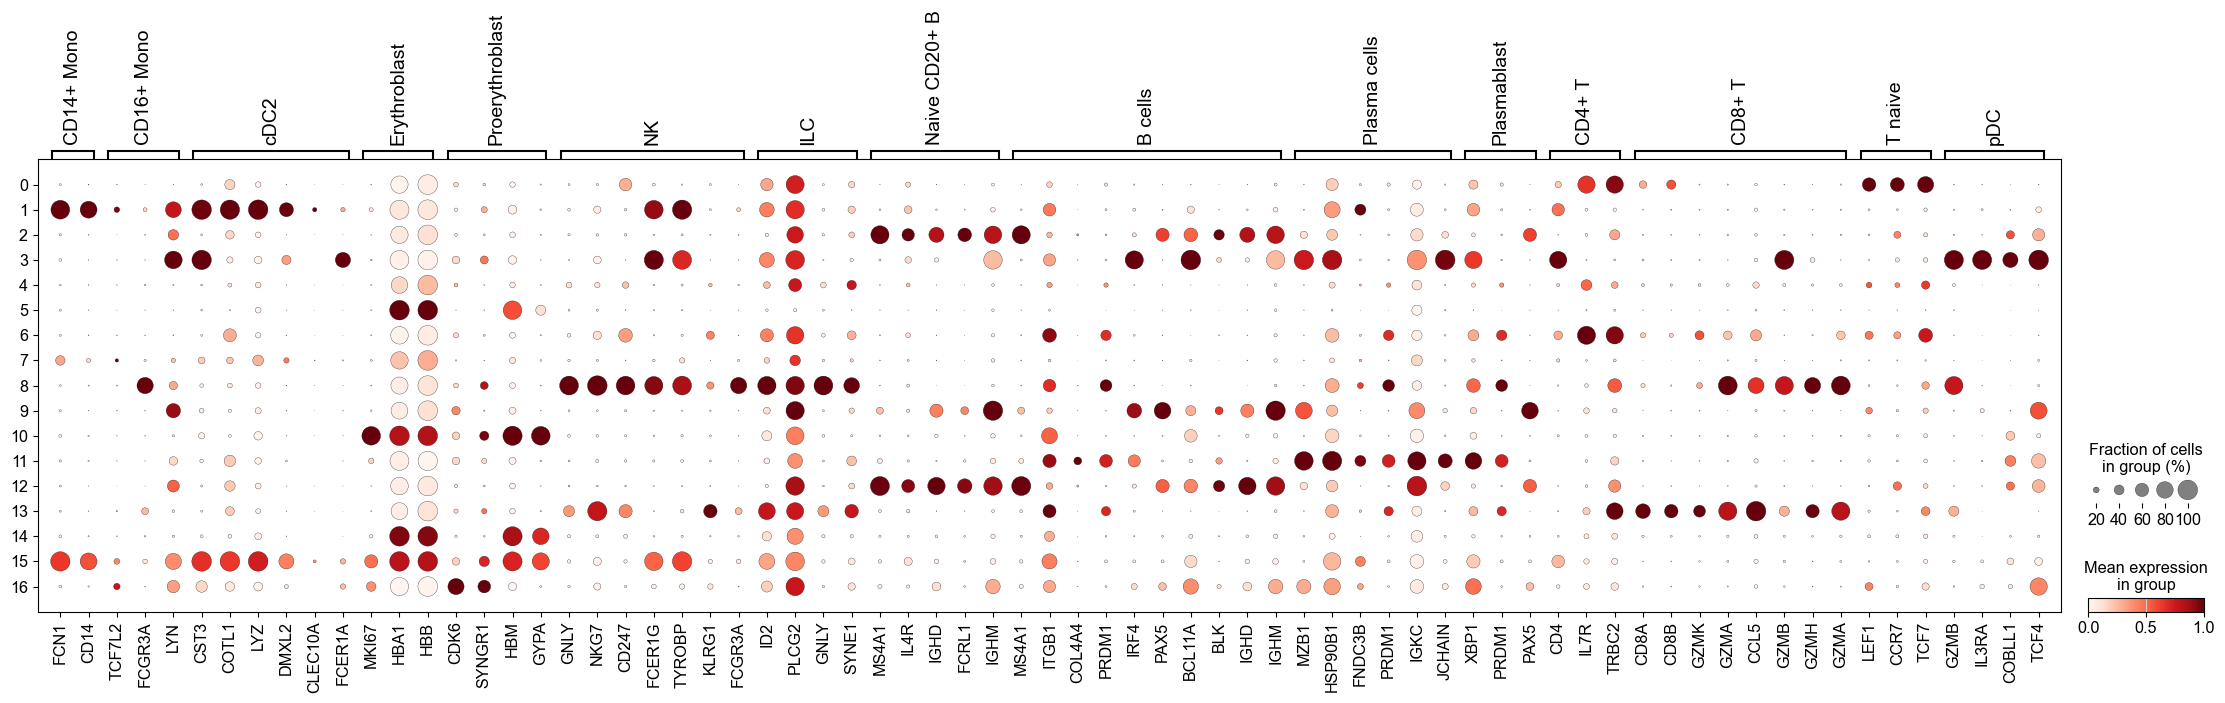

In [42]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

Differentially-expressed genes as markers
calculate marker genes per cluster
link marker genes with known biology (cell types / states) with statistical tests (wilcoxon, t-test)

In [43]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

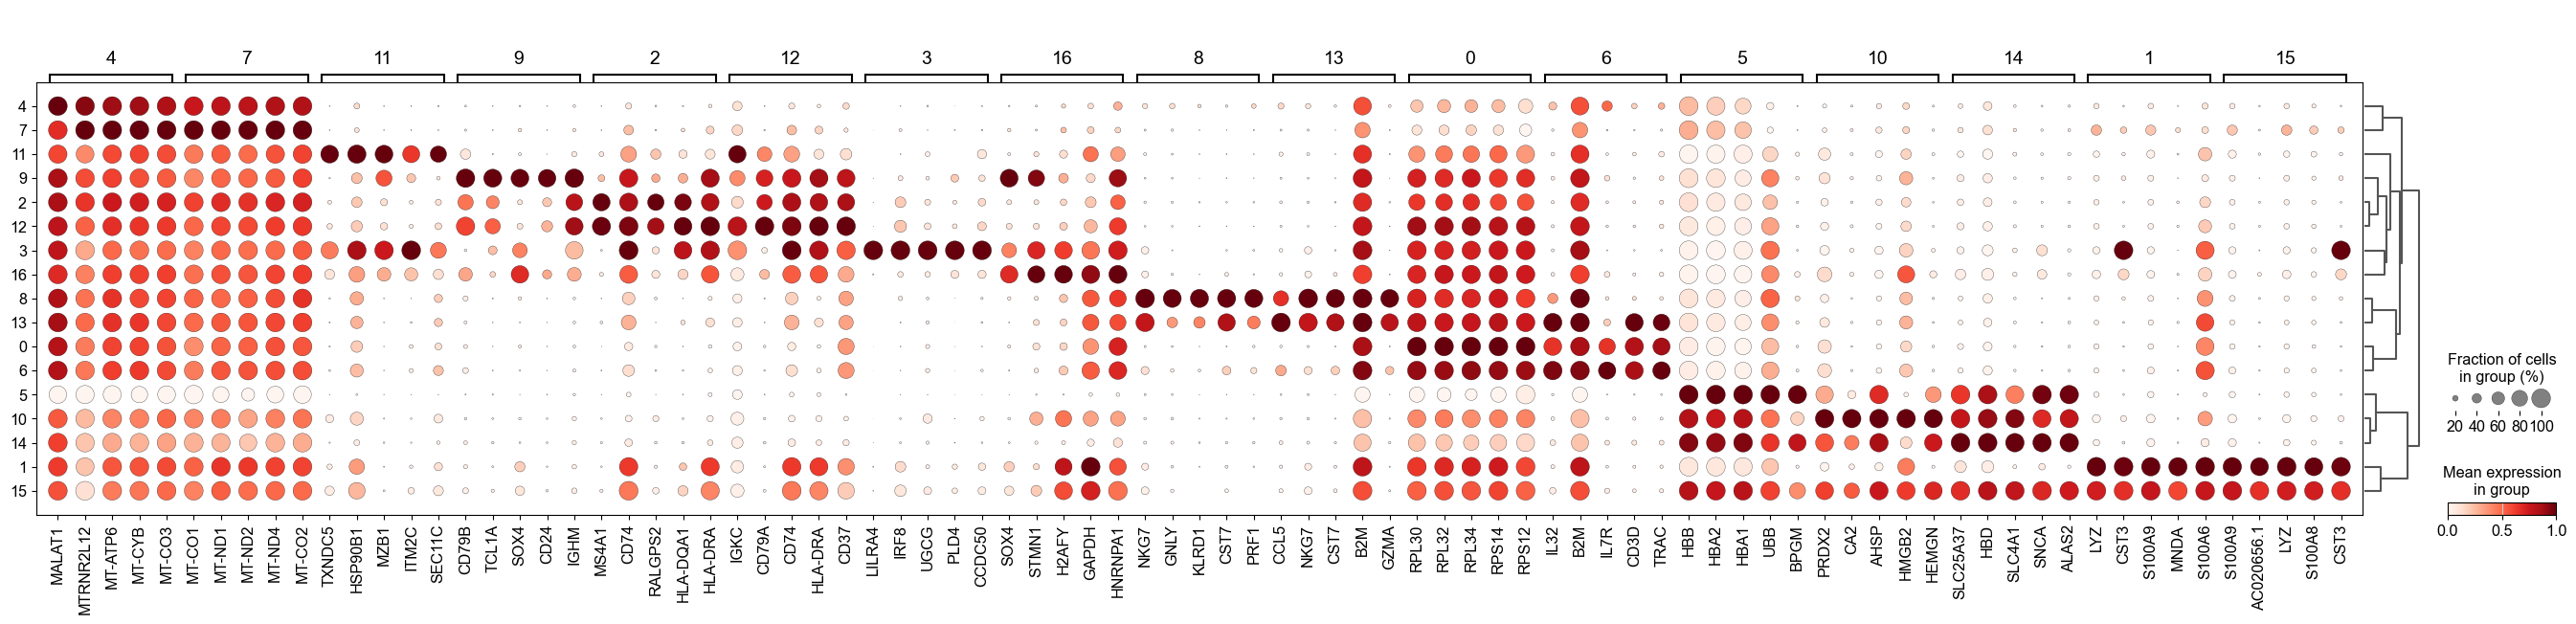

In [44]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

In [ ]:
sc.get.rank_genes_groups_df(adata, group="7").head(5)
# the tutorial seemed to have removed mitochondrial genes (but I did not)

,names,scores,logfoldchanges,pvals,pvals_adj
0,MT-CO1,44.801826,3.268034,0.0,0.0
1,MT-ND1,44.456486,3.373596,0.0,0.0
2,MT-ND2,44.144886,3.370348,0.0,0.0
3,MT-ND4,43.976067,3.123766,0.0,0.0
4,MT-CO2,43.846478,3.216703,0.0,0.0


very low pvals bc the statistical test used considers each cell as an independent sample

to be more conservative, "pseudo-bulk" the data by sample and use a more "powerful" differential expression tool (pydeseq2)

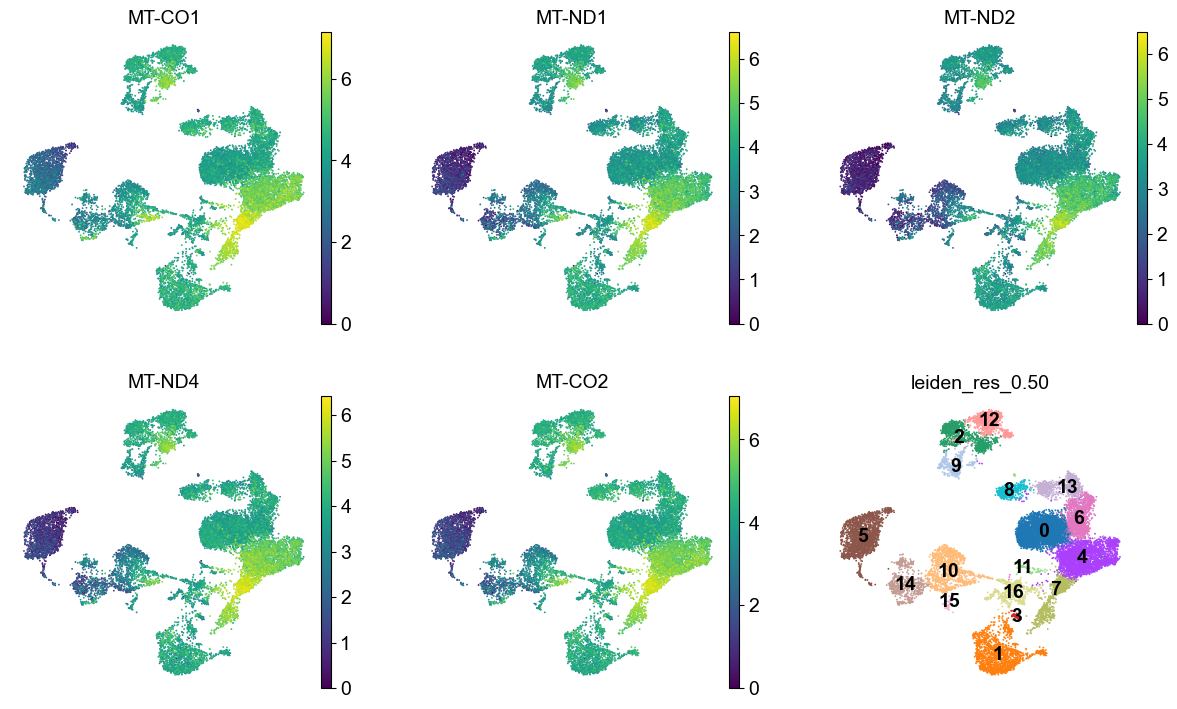

In [46]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

umap slightly different from tutorial. numbering is also different